# Gradient Boosting Model

In [31]:
%matplotlib inline
import matplotlib.pylab as pylab
pylab.rcParams['figure.figsize'] = 16, 12
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from xgboost.sklearn import XGBClassifier
from xgboost.plotting import plot_importance, plot_tree

In [41]:
path = '../datasets/processed/'
train_users = pd.read_csv(path + 'train_users.csv')
train_users = train_users.head(2000)
test_users = pd.read_csv(path + 'test_users.csv')
test_users = test_users.head(2000)

In [42]:
y_train = train_users['country_destination']
train_users.drop('country_destination', axis=1, inplace=True)
train_users.drop('id', axis=1, inplace=True)

x_train = train_users.values

test_users.drop('id', axis=1, inplace=True)

x_test = test_users.values

label_encoder = LabelEncoder()
encoded_y_train = label_encoder.fit_transform(y_train)

xgb = XGBClassifier(
    max_depth=8,
    learning_rate=0.2,
    n_estimators=45,
    gamma=0,
    min_child_weight=1,
    max_delta_step=0,
    subsample=0.6,
    colsample_bytree=0.6,
    colsample_bylevel=1,
    reg_alpha=0,
    reg_lambda=1,
    scale_pos_weight=1,
    base_score=0.5,
    seed=42
)

xgb.fit(x_train, encoded_y_train)

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.6,
       gamma=0, learning_rate=0.2, max_delta_step=0, max_depth=8,
       min_child_weight=1, missing=None, n_estimators=45, nthread=-1,
       objective='multi:softprob', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=42, silent=True, subsample=0.6)

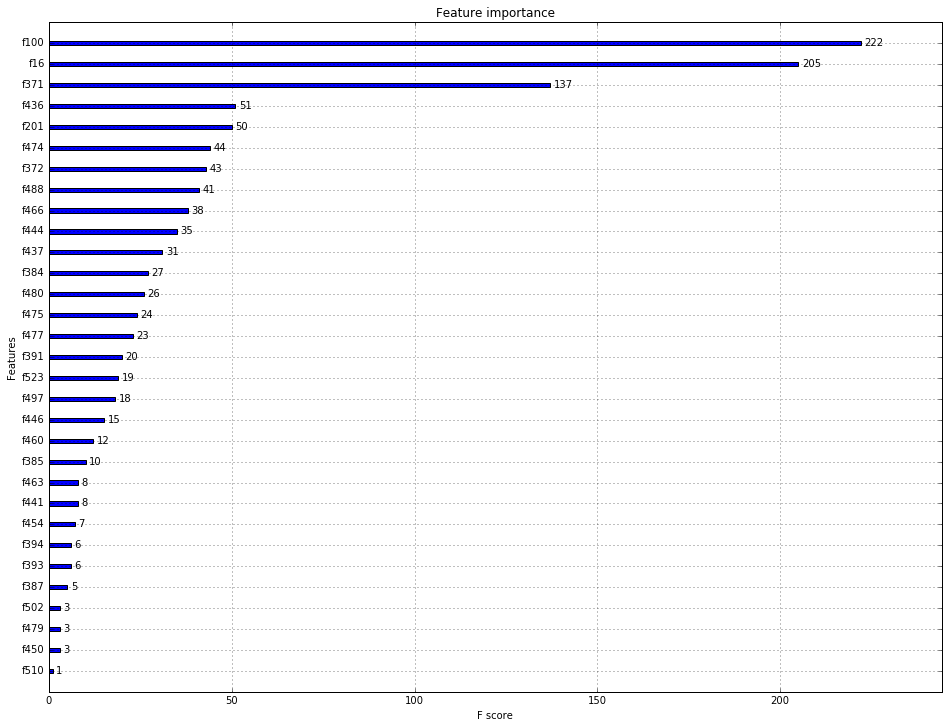

In [36]:
plot_importance(xgb)